<h1> Industry portfolio allocation using CNN and LSTM </h1>

The aim of this project is to be able to forecast the price of different industry sector based on a long historical time serie of industry aggregated prices using either a Convolutional Network or an Long Short-Term Memory neural network.  
Through predicted prices we can compute optimal weights giving the best return of the porfolio composed of all industry sectors.  

<h3> Business goal </h3>

The business objective is to be able to predict weights for a portfolio composed of industry components.  
Having this prediction will enable to allocate on which industry an investor should bet for beating the market.  

### Data

Data is composed of financial market performance accross 49 US industries on monthly periods from may 1925 until may 2024.  

Data was compliled by Professor Kenneth R. French and available on his website.  
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html  
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_49_ind_port.html  
The original data comes from CRSP financial database (https://www.crsp.org/) (affiliate of the University of Chicago)  
Dataset is composed of two CSV files.  

The first one is the market monthly including dividends returns of 49 industries and the second the number of firms in each industry.    

For our analysis we will only use data from January 2020.  
This represent a set of 293 months for 49 industries.  

I've used ex-dividend average value weighted (so a company in the industry return is represented by its value / (sum value of all companies of the industry sector)) return series.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc
from scipy.optimize import minimize
import seaborn as sns
from datetime import datetime
from bokeh.plotting import figure, show,output_notebook, show
from bokeh.palettes import Dark2_5 as palette
from bokeh.models import Legend
import itertools
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
# files
filename = '49_Industry_Portfolios_Wout_Div.csv'
nb_firms_filename = '49_Industry_Portfolios_Wout_Div-eq-w-nb-firms.csv'

df_returns = pd.read_csv("project_data/{}".format(filename), sep=",")
df_nb_firms = pd.read_csv("project_data/{}".format(nb_firms_filename), sep=",")

### Data cleaning

The original dataset use -99.99 for unavialable value. I've replace -99.99 by NaN on dataframe.    
Percentages on the original dataset are not in percentage value we should thus divide by 100.  

In [3]:
# replace NaN values 
df_returns=df_returns.replace(-99.99, np.nan)

# remove whitespaces in industry names
df_returns.rename(columns=lambda x: x.strip(), inplace=True)

# convert date string as datetime 
df_returns['Date'] = pd.to_datetime(df_returns['Date'], format='%Y%m')
df_nb_firms['Date'] = pd.to_datetime(df_nb_firms['Date'], format='%Y%m')

# cut the dataset
# filter data for using only data from January 2000 to May 2024
df_returns = df_returns.loc[(df_returns['Date'] > '2000-01-01')]
df_nb_firms = df_nb_firms.loc[(df_nb_firms['Date'] > '2000-01-01')]

# reset index following cut 
df_returns.reset_index(drop=True, inplace=True)
df_nb_firms.reset_index(drop=True, inplace=True)

# extract dates and remove them from datasets (returns and number of firms) 
dates = df_returns['Date']
df_returns = df_returns.drop(['Date'], axis=1)
df_nb_firms = df_nb_firms.drop(['Date'], axis=1)

# to a percentage value
df_returns = df_returns/100 

df_returns.head(n=10)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,0.0681,-0.0737,-0.0866,-0.1172,-0.0400,0.0029,-0.0333,-0.0039,-0.1181,-0.1073,...,-0.1298,-0.0551,0.0156,-0.0420,-0.1206,-0.1150,-0.1319,0.0198,0.0667,-0.0140
1,0.0419,0.1014,-0.0055,-0.0017,0.0272,0.0761,0.1114,0.1261,-0.1479,0.2477,...,0.1267,0.1263,0.0690,0.1435,0.1602,0.1478,0.2323,0.0410,0.1485,-0.0201
2,-0.0583,-0.0528,-0.0061,0.0369,0.0383,0.0005,0.0442,-0.0771,0.0442,0.0367,...,-0.0826,0.0345,-0.0315,-0.0552,0.0372,-0.0305,-0.0011,-0.0347,-0.1131,0.0879
3,-0.0133,0.1716,-0.0725,0.1182,0.1939,0.0098,0.0135,-0.0664,0.0275,-0.0562,...,-0.0289,-0.0383,0.0126,-0.0317,-0.0427,0.0770,0.0615,-0.0245,-0.0667,0.1041
4,0.0022,0.0158,0.0109,0.0579,0.0117,-0.0186,-0.0098,-0.0027,-0.0295,-0.0792,...,-0.0321,-0.0198,-0.0251,-0.0202,-0.0398,-0.1003,-0.0285,-0.0162,0.1442,0.0302
5,-0.0478,-0.0190,0.1335,0.0658,-0.0448,-0.0996,-0.0115,-0.0157,-0.0269,0.0556,...,-0.0031,0.0966,0.0425,-0.0201,-0.0200,0.0819,0.0935,0.0305,0.0835,-0.0184
6,-0.0094,-0.0312,-0.0221,-0.1102,0.1901,0.0183,0.0565,0.0182,0.0371,0.0298,...,0.0110,-0.0299,0.1026,-0.0534,-0.0073,0.0993,0.0418,-0.0008,0.1856,0.1369
7,0.0445,0.0579,-0.1004,0.0521,-0.0085,-0.0006,-0.0947,0.0033,-0.0149,-0.0079,...,-0.1221,-0.0297,0.0350,0.0241,0.0160,0.0368,0.0743,-0.0159,-0.0755,-0.0143
8,-0.1085,0.0642,0.1342,0.0900,0.2287,0.0676,-0.0432,-0.0218,0.0924,0.0385,...,0.0075,0.0801,-0.0299,-0.0211,0.0427,-0.0126,0.0406,0.0022,-0.0565,-0.0536
9,-0.0111,0.0355,0.1538,0.0389,0.0406,-0.0679,-0.1334,-0.0614,0.0013,0.0417,...,-0.1520,0.0128,-0.0690,-0.0029,0.0475,-0.0379,-0.0069,0.0180,-0.1899,-0.0840


In [4]:
df_returns.describe()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,...,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000
mean,0.008646,0.005609,0.007877,0.005736,0.010017,0.004128,0.010277,0.003002,0.004561,0.010031,...,0.008370,0.008227,0.007545,0.008354,0.009496,0.004996,0.008016,0.007623,0.007428,0.004165
std,0.064532,0.037941,0.058362,0.041179,0.064471,0.071122,0.084377,0.063803,0.040229,0.065653,...,0.058711,0.058046,0.050356,0.049813,0.049327,0.064311,0.053185,0.082829,0.070673,0.053372
min,-0.182200,-0.112700,-0.225000,-0.147000,-0.230900,-0.234200,-0.322800,-0.247900,-0.147900,-0.219800,...,-0.196000,-0.178900,-0.212100,-0.146300,-0.221600,-0.281800,-0.270500,-0.367500,-0.262200,-0.195200
25%,-0.033725,-0.015900,-0.019975,-0.018525,-0.028575,-0.037700,-0.037350,-0.031425,-0.017325,-0.025950,...,-0.027050,-0.024375,-0.022500,-0.019800,-0.020175,-0.030500,-0.017725,-0.030225,-0.036175,-0.024450
50%,0.008000,0.007100,0.008950,0.005500,0.017000,0.008900,0.010550,0.002100,0.006400,0.011100,...,0.009100,0.011000,0.010800,0.008400,0.011650,0.011100,0.012300,0.012550,0.011900,0.004400
75%,0.043900,0.027050,0.042475,0.032675,0.045550,0.043425,0.059375,0.032675,0.030300,0.047225,...,0.047025,0.045475,0.040200,0.036325,0.040350,0.039025,0.037075,0.044925,0.053575,0.038800
max,0.205800,0.171600,0.286100,0.118200,0.324600,0.228200,0.412700,0.304400,0.113600,0.247700,...,0.187400,0.171400,0.157800,0.185600,0.186700,0.196500,0.232300,0.652200,0.191800,0.166600


Distribution of the number of firms for each industry between from 2020 to 2024

<Axes: >

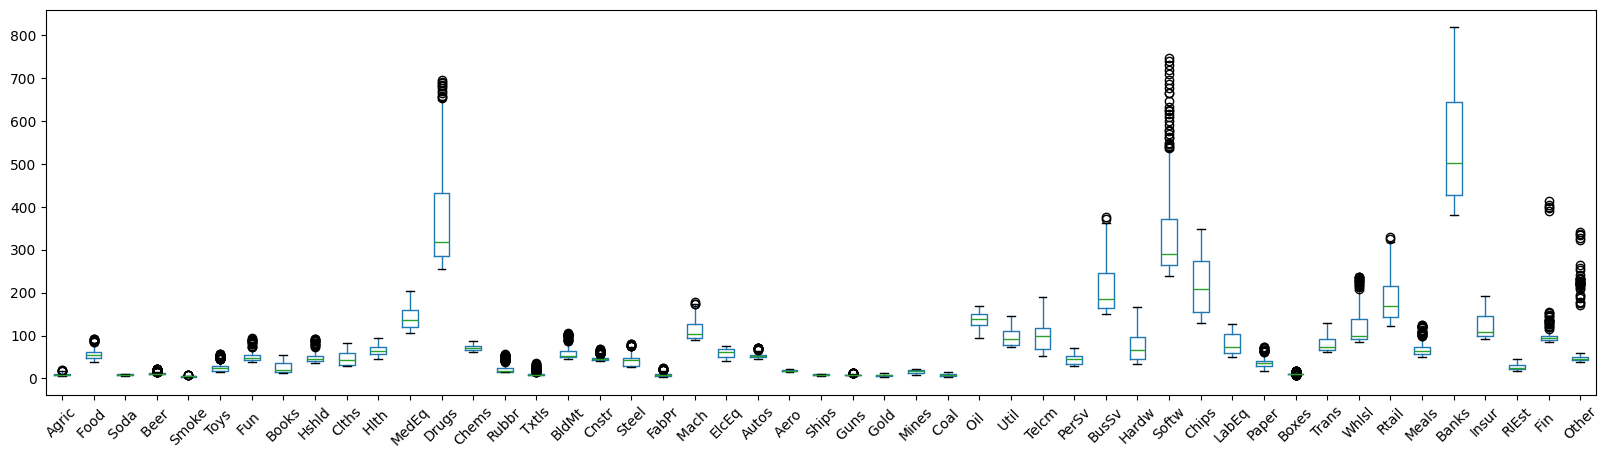

In [5]:
df_nb_firms.boxplot(grid=False, rot=45, fontsize=10, figsize=(20,5))

Distribution of returns for each industry between from 2020 to 2024

In [6]:
df_returns.boxplot(grid=False, rot=45, fontsize=10, figsize=(20,5))

<Axes: >

In [7]:
# add first date to dates
dates.loc[-1] = datetime(2000, 1, 1)
dates.index = dates.index + 1  
dates = dates.sort_index()
dates = dates.dt.date

# Individual price performance over the time

Display the performance of each industry.  
For each industry we can compute an index performance starting at a base value at the beginning.

In [8]:
def rebase_prices(df_returns, base_value=1):
    '''
    Create price series from a base value at the first date
    '''
    # compute compunded returns
    prices =  df_returns.add(1).cumprod().sub(1)
    prices = base_value * prices.add(1)
    # add the initial value at bottom
    base_vec = base_value * np.ones(df_returns.shape[1])
    prices.loc[-1] = base_vec
    # shifting index
    prices.index = prices.index + 1 
    # sorting by index for having the initial at the first index
    prices = prices.sort_index() 
    return prices

df_prices = rebase_prices(df_returns=df_returns)

In [9]:
def display_prices(df_prices):
    output_notebook()

    p1 = figure(x_axis_type="datetime", title="Industries performance", width=900, height=500)
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = 'Price'

    legend_items = []
    colors = itertools.cycle(palette) 
    for column_name in df_prices.columns:
        prices = df_prices[column_name]
        c = p1.line(dates, prices,  color=next(colors))
        legend_items.append((column_name, [c]))
    legend = Legend(items=legend_items, nrows=4)
    legend.click_policy="mute"
    legend.orientation = 'horizontal'
    p1.add_layout(legend, 'below')
    p1.legend.click_policy="hide"

    show(p1, notebook_handle=True) 

display_prices(df_prices=df_prices)

Loading BokehJS ...

As a benchmarck we can plot an equally weighted portfolio where all industry are equally represented.  
This portfolio will be used as reference for comparing with the different model we will use.  

In [10]:
# Composite index composed equally weighted components 
def eqw_portfolio(df_returns, base_value=1):
    '''
    Composite index composed equally weighted components 
    '''
    eqw = df_returns.sum(axis=1)/len(df_returns.columns)
    eqw_price_return =  eqw.add(1).cumprod()
    eqw_price_return = np.insert(eqw_price_return, 0, base_value, axis=0)

    p1 = figure(x_axis_type="datetime", title="Equally weighted industries performance", width=900, height=500)
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = 'Price'
    p1.line(dates, eqw_price_return)
    show(p1, notebook_handle=True)

eqw_portfolio(df_returns)

# Portfolio diversification selection

Our goal is to build an optimal portfolio so the one that do not buy all the industries but a substet of it, having a good diversification and nice returns.  
We can thus wonder if there is a high or low correlation between each industry on the whole period from 2020 to 2024.  
For this we can plot the correlation matrix. 

In [11]:
cov = df_returns.corr()
sns.clustermap(cov, cmap='plasma', yticklabels=True, xticklabels=True)

We can see that some sectors experience high correlation with other ones like the transportation sector with the chemical while other ones like Guns vs Sotfoware experience a very low correlation.  
We can thus wonder if we could find some sub industry group for having an idea of the different cluster of sectors.  
We will try with a dendogram plot.  
We see that some cluster appears like Guns/Smoke or Beer/Soda/Food.  
The idea would be thus to buy only a small part of some clusted because of their higly correlation feature.  

In [12]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(cov, method='ward'), labels=df_returns.columns)
plt.axhline(y=1.5, color='r', linestyle='--')

With the dendogram we could say that we could limit us to 7 groups of industries for having a right representation.  
We will verify this point with k-means algorithm.  

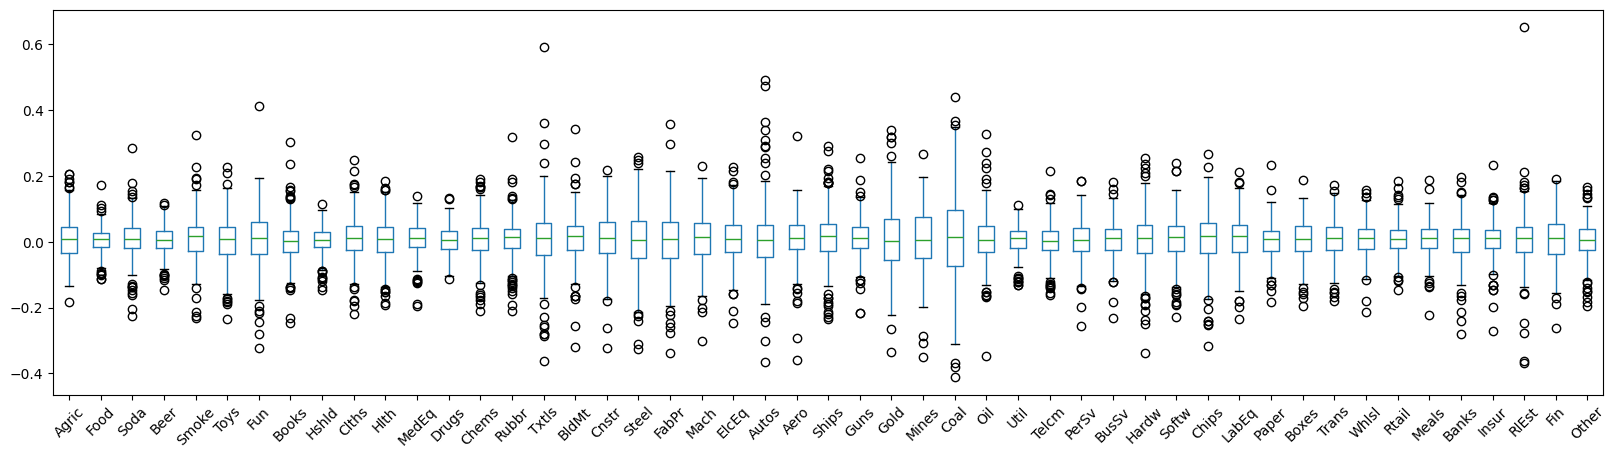

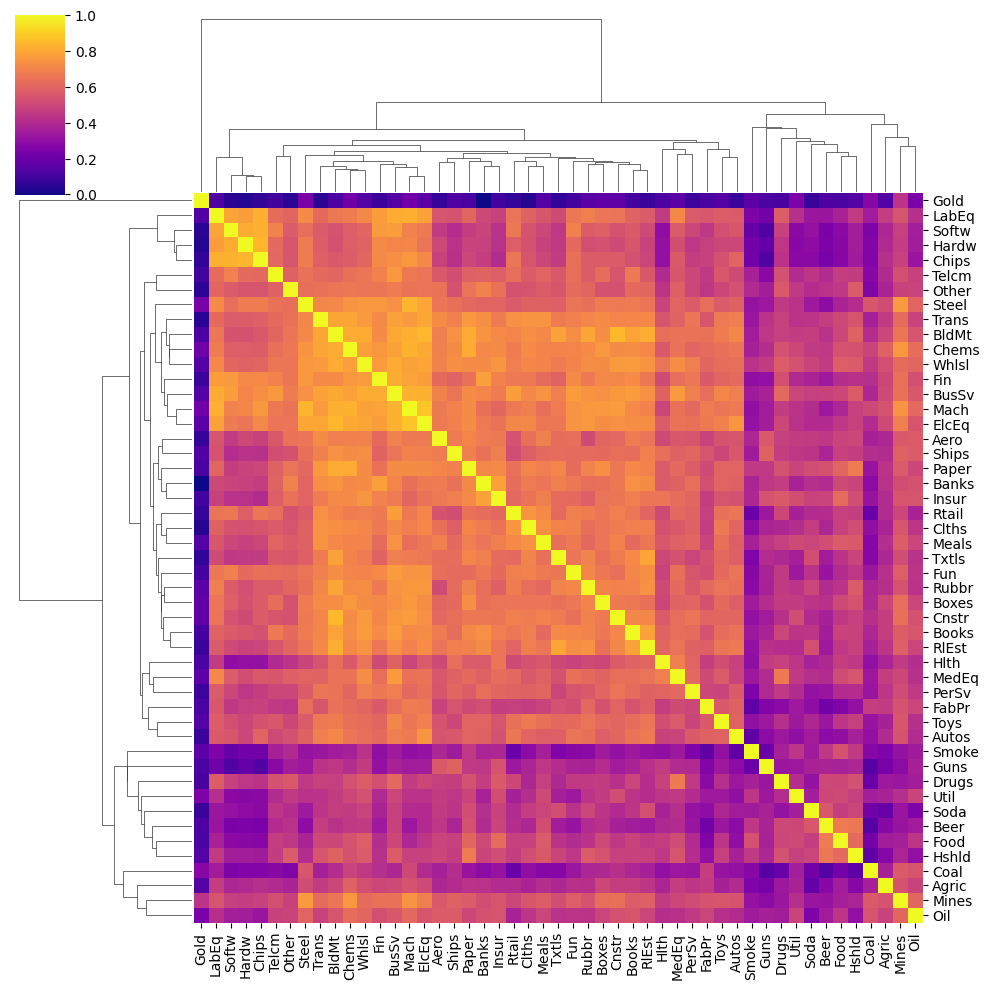

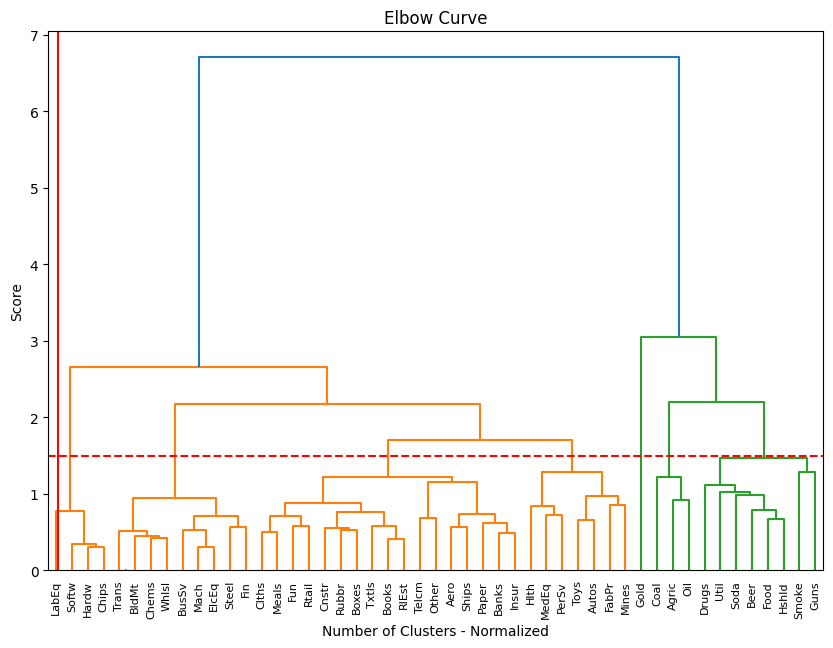

In [13]:
nb_clusters = range(1, 50)
kmeans = []
for i in nb_clusters:
    km = KMeans(n_clusters=i)
    kmeans.append(km)

score = []
for i in range(len(kmeans)):
    score.append(kmeans[i].fit(cov).score(cov)) #inertia_) 

plt.plot(nb_clusters, score)
plt.xlabel('Number of Clusters - Normalized')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.axvline(x = 6, color = 'r', label = 'axvline - full height')
plt.show() 

With K-Means we can see that the inflexion point is around 6 clusters.  
So this tell us that we could buy 6-7 sub sectors for having the right diversification of our portfolio.  
We will keep 7 as the number of underlying sector that will compose our portfolio.  
This translated in 14% maximum weight for an industry selected.  

# Predictive models 

Now we have set the maximum weight of each component our model will be use we have to now which component to select.  
We will try to forecast the performance of each industry.  
So the output of the model is scalar.  
For the two models i've used the standard scaler for scaling our series.  
I have also tester MinMax scaler but gave me no so good results.
Once the forecasting part is done we select the industries which we want to select on our universe for building our portfolio.  
For this I have tested two different models : a Convolutional Neural Network and a Long Term Short Term recurent neural network.  
The porfolio weight will be made through Sequential Least SQuares Programming optimization technique knowning forecasted returns.  

Performance metrics for our diffrent models: 

In [14]:
def mae(y, y_pred):
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred):
    return np.mean(np.square(y - y_pred))

def rmse(y, y_pred):
    return np.sqrt(mse(y, y_pred))

### Split Train/Test set 

I have choosen 80% of my dataset for training my model and 20% for testing.  
This split has been selected arbitrarily.

In [15]:
# split returns in train/test 
train_size = int(0.8 * df_prices.shape[0])
X_train, X_val= df_prices[:train_size], df_prices[train_size:]

In [16]:
def get_device() :
    # Set the device used by torch
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() :
        device = "mps"
    print(f"Using {device} device")
    return device

device = get_device()

Using mps device


Utility functions for creating sequences that will feed networks.

In [17]:
def create_seq(data, seq_length):
    """ 
        Create sequences of size `seq_length` from data input
        Sequences x and y are numpy arrays like
    """
    x, y = [], []
    for i in range(len(data) - seq_length-1):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

def create_tensor_seq_cnn(data, seq_length, device):
    """
        Create tensor like sequences for feeding the neural network
        Returns x (nn inputs) as tensor like object and y as numpy array
    """
    x_, y_ = create_seq(data, seq_length)
    # Reshape the input data for the CNN
    # x train is shape number of batche
    # s x 1 x seq length
    x_ = x_.reshape(x_.shape[0], 1, x_.shape[1])
    # transform x to torch tensor for being used by the model
    x_ = torch.from_numpy(x_).to(device)
    # Keep y has it is
    return x_, y_

### Convolutional Neural Network Model

For the convolutional layer I have used a 64 kernels with kernel of 2.  
It is followed by three simple neural network layers.  
The optimizer use the Adam algorithm (best performance during my trials).  
The loss function use is the mean squared error.  
The output our CNN is a scalar.

In [18]:
class CNN(nn.Module):
    def __init__(self, seq_length:int,  name=None):
        super(CNN, self).__init__()
        self.seq_length = seq_length
        if name:
            self.name = name
        # input is (1, seq_length)
        self.conv1 = nn.Conv1d(1, 64, kernel_size=2) 
        # seq length input; 64 channel ouput and 2 is the filter size  => 
        # output size = (seq length  + 2*0 - 2) / 1 + 1  
        # output size = seq length - 2 +1 
        # output size = seq length - 1
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2) 
        # output size = ((seq length - 1) + 2*0 - 2)/2  + 1 
        # output size = (seq length - 3)/2 + 1 
        self.fc1 = nn.Linear(64*int(( self.seq_length- 3)/2+1), 150)
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50,1)

        # Activation function: ReLU will be used
        self.relu = nn.ReLU()

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        # Input shape is assumed to be [batch_size, 1, seq_length]
        x = self.pool1(self.relu(self.conv1(x)))
        # Flatten the tensor
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
class CNNIndustryModel:
    """
        Convolutional Neural Network wrapper created for our specific problem
        `industry_name` is used only for the creation of a custom name
        `seq_length` is used for dimension the CNN 

    """
    def __init__(
            self, 
            device: str, 
            industry_name:str, 
            seq_length:int) -> None:
        # statics
        self.device = device
        self.industry_name = industry_name

        # CNN model
        self.seq_length = seq_length
        self.model = None
        self.optimizer = None
        self.loss_function = None
        self.__make_model()

    def name(self)->str:
        return "cnn - {}".format(self.industry_name)        

    def __make_model(self):
        self.model = CNN(self.seq_length, self.name()).to(self.device)
        # Loss function
        self.loss_function = nn.MSELoss()
        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001) 

    def train(self, nb_epoch, x_train, y_train, epoch_iter):
        # loop over the dataset multiple times
        running_loss = 0.0
        losses = []
        for epoch in range(nb_epoch+1): 
            outputs = self.model.forward(x_train) # forward pass
            # zero the parameter gradients
            self.optimizer.zero_grad()
            # forward + backward + optimize
            loss = self.loss_function(outputs.squeeze(), y_train)
            loss.backward()
            self.optimizer.step()

            # print statistics
            running_loss += loss.item()
            if epoch %  epoch_iter == 0:
                print(f'Epoch [{epoch + 1}/{nb_epoch}], Loss: {running_loss/100 :.4f}')
                running_loss = 0.0
                losses.append(loss.cpu().detach().numpy())
        return losses

I've used 10000 epoches for training our model and sequence length of 30.  
I've manually tester for lesser epoches and different sequences both given lower results.

In [20]:
cnn_nb_epoch = 10000
cnn_seq_length = 30
cnn_epoch_iter = 1000

# This will store the 3 performance criteria for each industry
cnn_model_perf = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'Validation Loss'], columns=df_returns.columns)
# This will contain the predicted prices
cnn_pred_prices = {}
# This will store the losses of our model during training for each (bulk) epoch.
cnn_model_loss = pd.DataFrame(index=[epoch for epoch in range(0, cnn_nb_epoch+1, cnn_epoch_iter)], columns=df_returns.columns)

def run_cnn_model(
        device:str, 
        nb_epoch:int, 
        seq_length:int, 
        epoch_iter:int, 
        industry_name:str, 
        checkpoint_path:str,
        load:bool=False,
        save:bool=False):
    """
        instanciate a model for each industry, fit with industry training data set and evaluate the model with validation set
    """

    scaler = MinMaxScaler()

    # instanciate CNN model
    m = CNNIndustryModel(device=device, industry_name=industry_name, seq_length=seq_length)
    
    checkpoint_filepath = "{}/{}.pt".format(checkpoint_path, m.name())

    train = scaler.fit_transform(X_train[industry_name].values.reshape(-1, 1) )  
    
    # load existing checkpoint
    if load:
        checkpoint = torch.load(checkpoint_filepath, weights_only=True)
        m.model.load_state_dict(checkpoint['model_state_dict'])
        m.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        nb_epoch = checkpoint['epoch']

    # train the model
    else: 
        # scale returns
        x_train, y_train = create_tensor_seq_cnn(train[:,0], seq_length=seq_length, device=device)
        # fit the model
        losses = m.train(nb_epoch, x_train, torch.from_numpy(y_train ).to(device), epoch_iter=epoch_iter)
        # store model losses
        cnn_model_loss[industry_name] = losses
        # evaluate the model
        m.model.eval()

    val = scaler.transform( X_val[industry_name].values.reshape(-1, 1))
    x_val, y_val  = create_tensor_seq_cnn(val[:,0], seq_length=seq_length, device=device)

    with torch.no_grad():
        val_outputs = m.model(x_val)
        val_loss = m.loss_function(val_outputs, torch.from_numpy(y_val).to(device))
        print(f'Validation Loss: {val_loss.item():.4f}')

    y_hat = m.model(x_val).squeeze().detach().cpu().numpy()
    y_hat = scaler.inverse_transform(y_hat.reshape(-1, 1) ) # inverse transformation

    # strore predicted prices
    cnn_pred_prices[industry_name] =  y_hat.flatten()

    # store model performance for each industry
    cnn_model_perf[industry_name] = [mae(y_val, y_hat), mse(y_val, y_hat), rmse(y_val, y_hat), val_loss.item()]

    if not save:
        return

    print('Saving model')
    torch.save({
        'epoch': nb_epoch,
        'model_state_dict': m.model.state_dict(),
        'optimizer_state_dict': m.optimizer.state_dict(),
        },  checkpoint_filepath)


Run the CNN for each industry

In [21]:
def run_cnn_industry_models(
        device:str, 
        nb_epoch:int, 
        seq_length:int, 
        epoch_iter:int, 
        checkpoint_path='./checkpoints',
        load:bool=False, 
        save:bool=False):
    for industry_name in df_returns.columns:
        run_cnn_model(
            device=device, 
            nb_epoch=nb_epoch, 
            seq_length=seq_length, 
            epoch_iter=epoch_iter,
            industry_name=industry_name,
            checkpoint_path=checkpoint_path,
            load=load,
            save=save)

In [22]:
run_cnn_industry_models(
    device=device, 
    nb_epoch=cnn_nb_epoch, 
    seq_length=cnn_seq_length, 
    epoch_iter=cnn_epoch_iter,
    save=False,
    load=True)

cnn - Agric: total params: 142343


/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size 

Validation Loss: 0.2170
cnn - Food: total params: 142343
Validation Loss: 0.0418
cnn - Soda: total params: 142343
Validation Loss: 0.0635
cnn - Beer: total params: 142343
Validation Loss: 0.3336
cnn - Smoke: total params: 142343
Validation Loss: 0.0233
cnn - Toys: total params: 142343
Validation Loss: 0.1159
cnn - Fun: total params: 142343
Validation Loss: 5.6938
cnn - Books: total params: 142343
Validation Loss: 0.0656
cnn - Hshld: total params: 142343
Validation Loss: 0.3378
cnn - Clths: total params: 142343
Validation Loss: 0.4704
cnn - Hlth: total params: 142343
Validation Loss: 0.8099
cnn - MedEq: total params: 142343
Validation Loss: 1.9886
cnn - Drugs: total params: 142343
Validation Loss: 0.2924
cnn - Chems: total params: 142343
Validation Loss: 0.0514
cnn - Rubbr: total params: 142343
Validation Loss: 1.5869
cnn - Txtls: total params: 142343
Validation Loss: 0.0617
cnn - BldMt: total params: 142343
Validation Loss: 1.7207
cnn - Cnstr: total params: 142343
Validation Loss: 0.91

/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size 

cnn - Mach: total params: 142343
Validation Loss: 0.7451
cnn - ElcEq: total params: 142343
Validation Loss: 0.8820
cnn - Autos: total params: 142343
Validation Loss: 20.8849
cnn - Aero: total params: 142343
Validation Loss: 0.0253
cnn - Ships: total params: 142343
Validation Loss: 0.1006
cnn - Guns: total params: 142343
Validation Loss: 1.2340
cnn - Gold: total params: 142343
Validation Loss: 0.0665
cnn - Mines: total params: 142343
Validation Loss: 0.1994
cnn - Coal: total params: 142343
Validation Loss: 0.0004
cnn - Oil: total params: 142343
Validation Loss: 0.0589
cnn - Util: total params: 142343
Validation Loss: 0.0197
cnn - Telcm: total params: 142343
Validation Loss: 0.0270
cnn - PerSv: total params: 142343
Validation Loss: 0.0544
cnn - BusSv: total params: 142343
Validation Loss: 0.0431
cnn - Hardw: total params: 142343
Validation Loss: 0.3886
cnn - Softw: total params: 142343
Validation Loss: 2.2933
cnn - Chips: total params: 142343
Validation Loss: 21.0117
cnn - LabEq: total p

/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size 

Utility function for merging actual and predicted prices and returns

In [23]:
def merge_pred_returns_and_prices(actual_prices, price_predictions): 
    '''
        Merge actual and forecasted prices and returns into two dataframes
    '''
    returns_pred_dct ={}
    pred_price_dct ={}
    for industry_name in df_returns.columns:
        y_pred = np.concatenate( 
            (actual_prices[industry_name][:len(actual_prices)-len(price_predictions[industry_name])].to_numpy(),
            price_predictions[industry_name]), 
            axis=0)
        pred_price_dct[industry_name] = y_pred
        returns_pred = y_pred[1:len(y_pred)]/y_pred[0:len(y_pred)-1]-1
        returns_pred_dct[industry_name] = returns_pred

    df_returns_pred =  pd.DataFrame.from_dict(returns_pred_dct)
    df_price_pred =  pd.DataFrame.from_dict(pred_price_dct)
    return df_returns_pred, df_price_pred

Utility functions for ploting prediction vs Actual prices or industries predictions

In [24]:
def plot_prediction(actual_prices, price_predictions, industry_name):
    # Get the true and predicted values for the current asset
    y_true = actual_prices[industry_name]
    y_pred = price_predictions[industry_name]

    # Plot true and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_true, label='True', color="#0066CC")
    plt.plot(dates, y_pred, label='Predicted', linestyle='--', color="#009900")

    # Add labels, legend, and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'True vs. Predicted Price for {industry_name}')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

def plot_industries_predictions(price_predictions):
    output_notebook()

    p1 = figure(x_axis_type="datetime", title="Industries performance predicted ", width=900, height=500)
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = 'Price'

    legend_items = []


    colors = itertools.cycle(palette) 

    for column_name in price_predictions.columns:
        prices = price_predictions[column_name]
        c = p1.line(dates, prices,  color=next(colors))
        legend_items.append((column_name, [c]))

    legend = Legend(items=legend_items, nrows=4)
    legend.click_policy="mute"
    legend.orientation = 'horizontal'
    p1.add_layout(legend, 'below')
    p1.legend.click_policy="hide"

    show(p1, notebook_handle=True) 

def display_model_perf(model_perfs, model_name: str, metric:str):
    fig, ax = plt.subplots(figsize =(16, 9))
    ax.set_xlabel(metric)
    ax.set_ylabel('Industry')
    ax.set_title('{} for {} model'.format(metric, model_name))
    ax.barh(df_returns.columns, width=model_perfs.filter(items=[metric], axis=0).values[0])
    fig.show()
    # Show plot
    plt.show()

def display_weights(weights, model:str):
    fig, ax = plt.subplots(figsize =(16, 9))
    ax.set_xlabel('Weight')
    ax.set_ylabel('Industry')
    ax.set_title('Weight for each industry with {} model'.format(model))
    ax.barh(df_returns.columns, width=weights)
    fig.show()
    # Show plot
    plt.show()



/var/folders/dg/c2dgqj9n6vjfcnsytns6g4ph0000gn/T/ipykernel_30933/2852449101.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


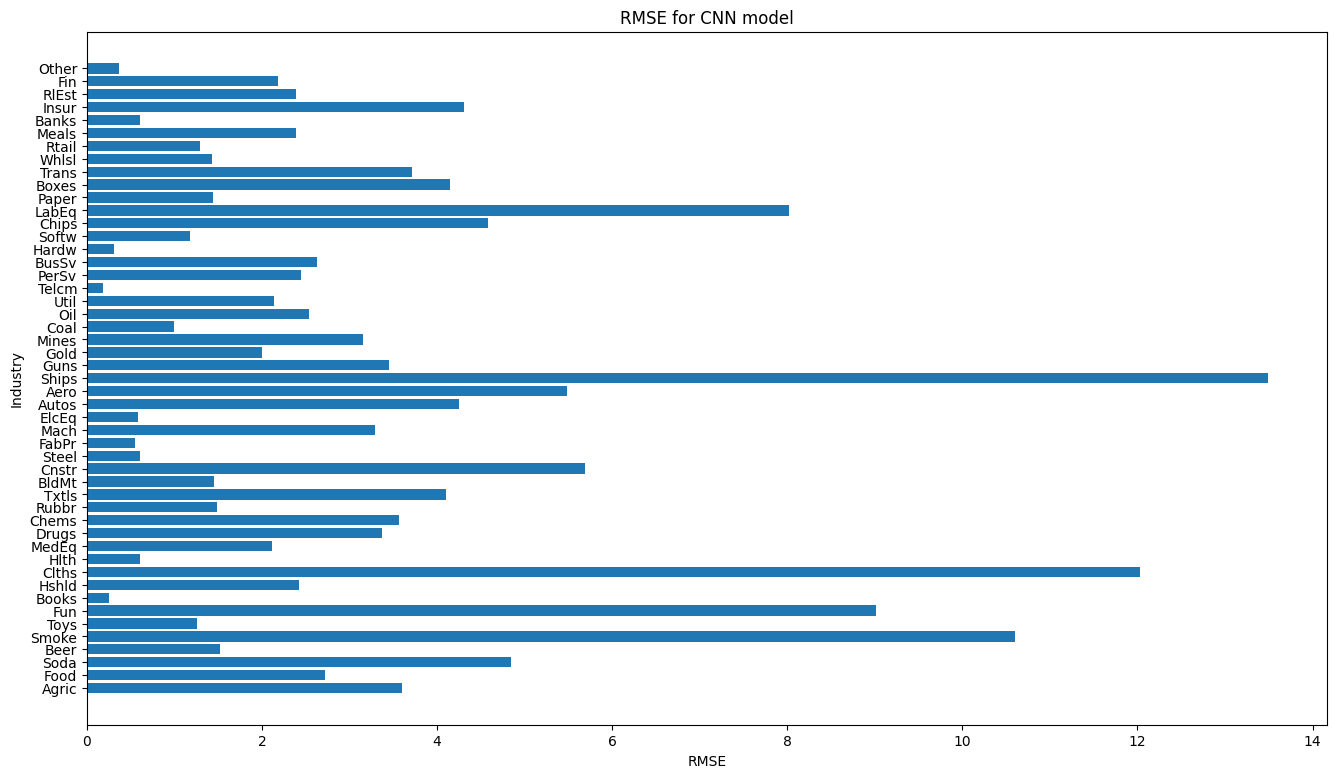

In [25]:
display_model_perf(cnn_model_perf, 'CNN' ,'RMSE')

/var/folders/dg/c2dgqj9n6vjfcnsytns6g4ph0000gn/T/ipykernel_30933/2852449101.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


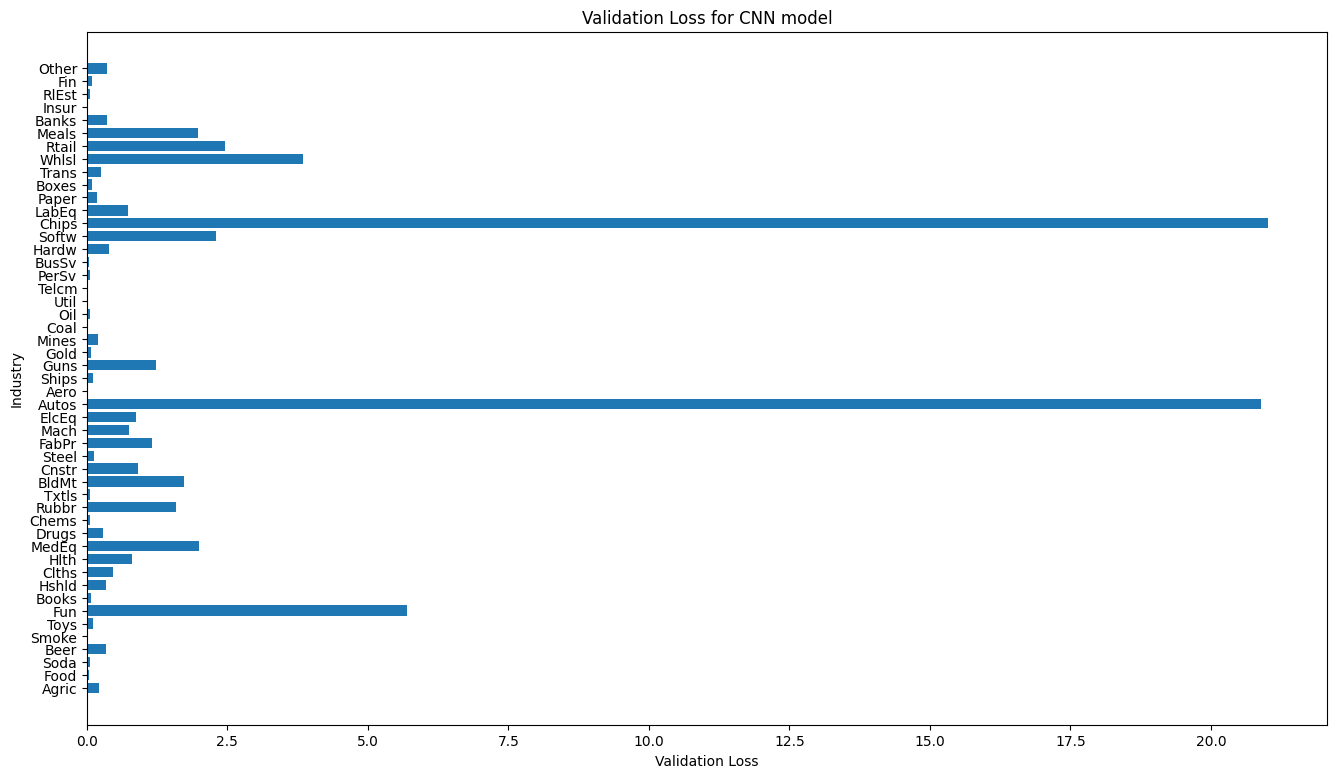

In [26]:
display_model_perf(cnn_model_perf, 'CNN' ,'Validation Loss')

In [27]:
df_cnn_returns, df_cnn_prices = merge_pred_returns_and_prices(df_prices, cnn_pred_prices)

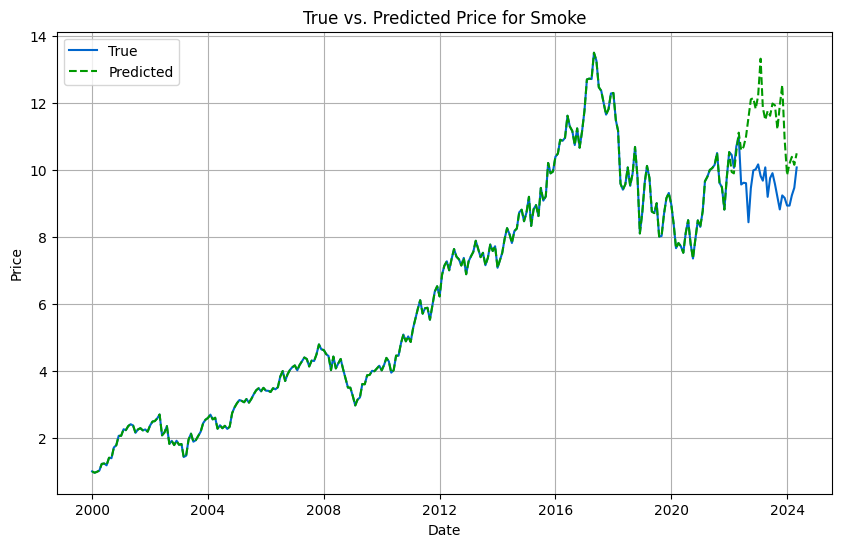

In [28]:
plot_prediction(actual_prices=df_prices, price_predictions=df_cnn_prices,  industry_name='Smoke')

Display predictions for all industries provided by the LSTM model.

In [29]:
plot_industries_predictions(df_cnn_prices)

Loading BokehJS ...

### Weights allocation computation

For computing weight we will use the Sequential Least Squares Programming (SLSQP) optimization.  
Constraints will be added for having :
- all weights equals to 1 (no leverage) 
- weights between 0% (no short position) and 15% (as expected before)

In [30]:
def objective(weights, predicted_returns):
    '''
    objective function for minimizer
    '''
    return  1.0 / predicted_returns.dot(weights).mean()

def compute_weights(nb_industries, pred_returns):
    '''
    Computed portfolio weights accroding to boundaries and condition given from predicted returns
    '''
    # initialize and equally 
    weights = np.ones(nb_industries) / nb_industries
    weights_init = weights 

    # we bound weights between 0 and 1 so it is a long only porfolio
    bounds = tuple((0.0, 0.15) for _ in range(nb_industries))

    # add constrains on weight 
    # we want that the sum of the weights should be 1
    constraints = ({
        'type': 'eq',
        'fun': lambda weight: np.sum(weight) - 1.0})

    # Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP)
    res = minimize(objective, weights_init, pred_returns, method='SLSQP', bounds=bounds, constraints=constraints)
    return res.x

utility function for ploting the portfolio performance versus an equally weighted portfolio.

In [31]:
def portfolio_perf(returns, weights, base_value=1):
    '''
    Composite index composed according to intput weights
    '''

    weighted_perf = (returns*weights).sum(axis=1)
    ptf_price_return =  weighted_perf.add(1).cumprod()
    eqw_price_return = (returns*(1.0/len(weights))).sum(axis=1).add(1).cumprod()

    ptf_price_return = np.insert(ptf_price_return, 0, base_value, axis=0)
    eqw_price_return = np.insert(eqw_price_return, 0, base_value, axis=0)

    p1 = figure(x_axis_type="datetime", title="Industries performance predicted", width=900, height=500)
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = 'Price'

    dtes = dates[len(dates)-len(weights)-1:len(dates)]
    p1.line(dtes, ptf_price_return, legend_label='Predicted portfolio', line_color='red')
    p1.line(dtes, eqw_price_return, legend_label='Equally weighted portfolio', line_color='blue')

    show(p1, notebook_handle=True)


In [32]:
# Compute weights only from predicted timeframe
cnn_pred_weights = compute_weights(len(df_returns.columns),  df_cnn_returns[df_returns.shape[0]-len(cnn_pred_prices):])

# plot prediction vs and equally weighted portfolio
portfolio_perf(df_returns[df_returns.shape[0]-len(cnn_pred_prices):], cnn_pred_weights)

/var/folders/dg/c2dgqj9n6vjfcnsytns6g4ph0000gn/T/ipykernel_30933/2852449101.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


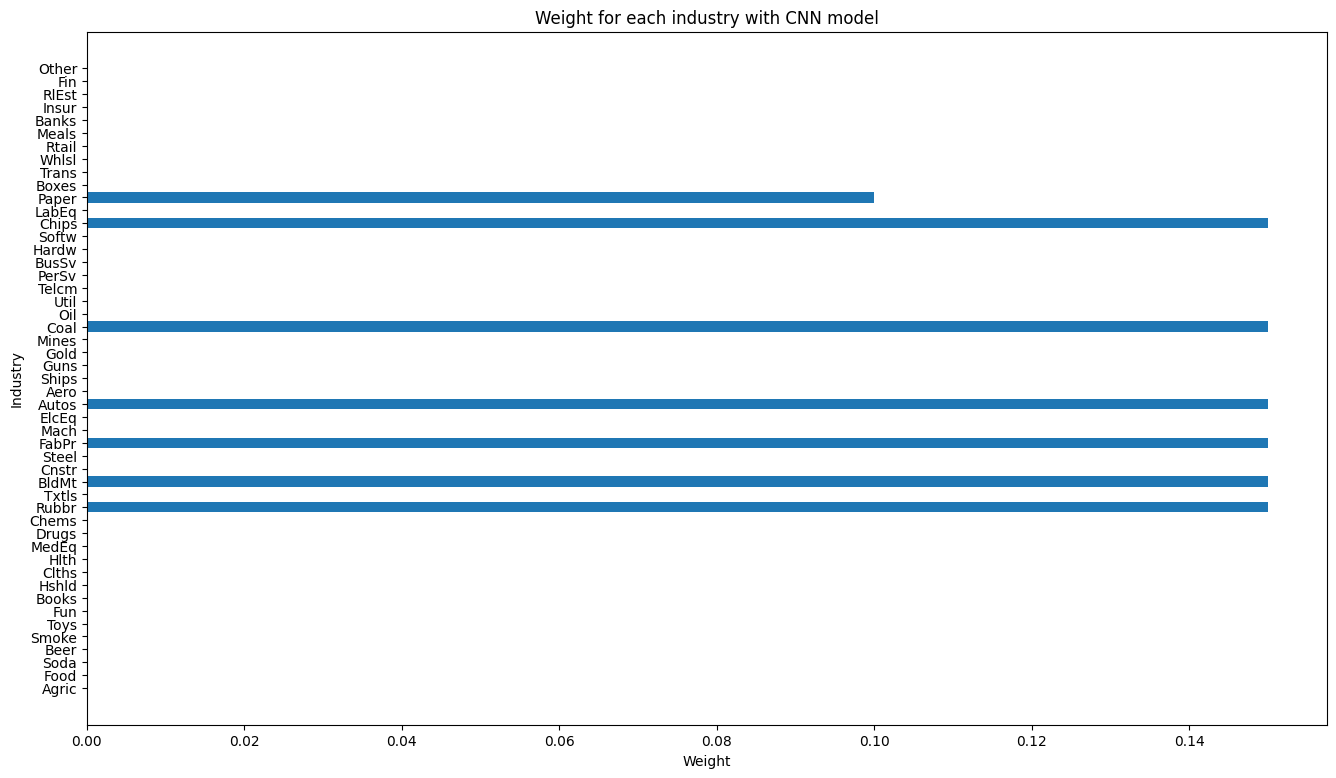

In [33]:
display_weights(cnn_pred_weights, "CNN")

### Long Term Short Term model 

For the LSTM i've used 50 hidden states and a dropout of 0.1 folowing by a simple neural network layer.   
I've kept the same optimizer and loss function as the CNN model.  
The optimizer use the Adam algorithm (best performance during my trials).  
The loss function use is the mean squared error.  
The output of the model is a scalar.  

In [34]:
class LSTM(nn.Module):
    def __init__(self,  hidden_size=50, num_layers=1, name=None):
        super(LSTM, self).__init__()
        if name:
            self.name = name
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=1, 
            hidden_size=50, 
            num_layers= self.num_layers,
            batch_first=True,
            dropout=0.1)
        self.fc = nn.Linear(self.hidden_size, 1)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [35]:
class LSTMIndustryModel:
    """
        Convolutional Neural Network wrapper created for our specific problem
        `industry_name` is used only for the creation of a custom name
        `seq_length` is used for dimension the CNN 

    """
    def __init__(
            self, 
            device: str, 
            industry_name:str,
            ) -> None:
        # statics
        self.device = device
        self.industry_name = industry_name

        # LSTM model
        self.model = None
        self.optimizer = None
        self.loss_function = None
        self.__make_model()

    def name(self)->str:
        return "lstm - {}".format(self.industry_name)        

    def __make_model(self):
        self.model = LSTM(name=self.name()).to(self.device)
        # Loss function
        self.loss_function = nn.MSELoss()
        # Optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)

    def train(self, nb_epoch, x_train, y_train, epoch_iter):
        # loop over the dataset multiple times
        running_loss = 0.0
        losses = []
        for epoch in range(nb_epoch+1): 
            #outputs = self.model.forward(x_train) # forward pass
            outputs = self.model.forward(x_train)
            # zero the parameter gradients
            self.optimizer.zero_grad()
            # forward + backward + optimize
            loss = self.loss_function(outputs, y_train)
            loss.backward()
            self.optimizer.step()

            # print statistics
            running_loss += loss.item()
            if epoch %  epoch_iter == 0:
                print(f'Epoch [{epoch + 1}/{nb_epoch}], Loss: {running_loss/100 :.4f}')
                running_loss = 0.0
                losses.append(loss.cpu().detach().numpy())
        return losses

I've used 5000 epoches for training the network. I've used different values and found that this value gave me the best results.  
The sequence length is shorter than the one used on CNN and is reduced to 10.  

In [36]:
lstm_nb_epoch = 5000
lstm_seq_length = 10
lstm_epoch_iter = 1000

# store model performance
lstm_model_perf = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'Validation Loss'], columns=df_returns.columns)
# will store the predicted prices for this model
lstm_pred_prices = {}
# store lossed at each bulk epoch
lstm_model_loss = pd.DataFrame(index=[epoch for epoch in range(0, lstm_nb_epoch+1, lstm_epoch_iter)], columns=df_returns.columns)

def run_lstm_model(
        device:str, 
        nb_epoch:int, 
        seq_length:int,
        epoch_iter:int, 
        industry_name:str, 
        checkpoint_path:str,
        load:bool=False,
        save:bool=False):
    """
        instanciate a model for each industry, fit with industry training data set and evaluate the model with validation set
    """

    # instanciate CNN model
    m = LSTMIndustryModel(device=device, industry_name=industry_name,)
    
    checkpoint_filepath = "{}/{}.pt".format(checkpoint_path, m.name())

    scaler = MinMaxScaler()

    train = scaler.fit_transform(X_train[industry_name].values.reshape(-1, 1))  
    
    # load existing checkpoint
    if load:
        checkpoint = torch.load(checkpoint_filepath, weights_only=True)
        m.model.load_state_dict(checkpoint['model_state_dict'])
        m.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        nb_epoch = checkpoint['epoch']

    # train the model
    else: 
        # scale returns
        x_train, y_train = create_seq(train, seq_length=seq_length)
        # Convert to PyTorch tensors
        x_train = torch.from_numpy(x_train).float().to(device)
        y_train = torch.from_numpy(y_train).float().to(device)
        # fit the model
        losses = m.train(nb_epoch, x_train, y_train, epoch_iter=epoch_iter)
        # store model losses
        lstm_model_loss[industry_name] = losses
        # evaluate the model
        m.model.eval()

    val = scaler.transform( X_val[industry_name].values.reshape(-1, 1))
    
    x_val, y_val  = create_seq(val, seq_length=seq_length)
    x_val = torch.from_numpy(x_val).float().to(device)

    with torch.no_grad():
        val_outputs = m.model(x_val)
        val_loss = m.loss_function(val_outputs, torch.from_numpy(y_val).float().to(device))
        print(f'Validation Loss: {val_loss.item():.4f}')

    y_hat = m.model(x_val)

    y_hat = y_hat.cpu().detach().numpy()
    y_hat = scaler.inverse_transform(y_hat) # inverse transformation

    # strore predicted prices
    lstm_pred_prices[industry_name] =  y_hat.flatten()
    # store model performance for each industry
    lstm_model_perf[industry_name] = [mae(y_val, y_hat), mse(y_val, y_hat), rmse(y_val, y_hat), val_loss.item() ]

    if not save:
        return

    print('Saving model')
    torch.save({
        'epoch': nb_epoch,
        'model_state_dict': m.model.state_dict(),
        'optimizer_state_dict': m.optimizer.state_dict(),
        },  checkpoint_filepath)

run the model for each industry

In [37]:
def run_lstm_industry_models(
        device:str, 
        nb_epoch:int, 
        seq_length:int, 
        epoch_iter:int, 
        checkpoint_path='./checkpoints',
        load:bool=False, 
        save:bool=False):
    for industry_name in df_returns.columns:
        run_lstm_model(
            device=device, 
            nb_epoch=nb_epoch,  
            seq_length=seq_length, 
            epoch_iter=epoch_iter,
            industry_name=industry_name,
            checkpoint_path=checkpoint_path,
            load=load,
            save=save)

In [38]:
run_lstm_industry_models(
    device=device, 
    nb_epoch=lstm_nb_epoch, 
    seq_length=lstm_seq_length, 
    epoch_iter=lstm_epoch_iter,
    save=False,
    load=True)

/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

lstm - Agric: total params: 10651
Validation Loss: 0.0282
lstm - Food: total params: 10651
Validation Loss: 0.0090
lstm - Soda: total params: 10651
Validation Loss: 0.0250
lstm - Beer: total params: 10651
Validation Loss: 0.0552
lstm - Smoke: total params: 10651
Validation Loss: 0.0038
lstm - Toys: total params: 10651
Validation Loss: 0.2140
lstm - Fun: total params: 10651
Validation Loss: 0.0940
lstm - Books: total params: 10651
Validation Loss: 0.0209
lstm - Hshld: total params: 10651
Validation Loss: 0.0342
lstm - Clths: total params: 10651
Validation Loss: 0.0638
lstm - Hlth: total params: 10651
Validation Loss: 0.1173
lstm - MedEq: total params: 10651
Validation Loss: 0.3752
lstm - Drugs: total params: 10651
Validation Loss: 0.2091
lstm - Chems: total params: 10651
Validation Loss: 0.0329
lstm - Rubbr: total params: 10651
Validation Loss: 0.2312
lstm - Txtls: total params: 10651
Validation Loss: 0.0076
lstm - BldMt: total params: 10651
Validation Loss: 0.1671
lstm - Cnstr: total p

/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

Validation Loss: 0.1021
lstm - Autos: total params: 10651
Validation Loss: 1.4255
lstm - Aero: total params: 10651
Validation Loss: 0.0806
lstm - Ships: total params: 10651
Validation Loss: 0.0277
lstm - Guns: total params: 10651
Validation Loss: 0.1526
lstm - Gold: total params: 10651
Validation Loss: 0.0102
lstm - Mines: total params: 10651
Validation Loss: 0.1020
lstm - Coal: total params: 10651
Validation Loss: 0.0000
lstm - Oil: total params: 10651
Validation Loss: 0.0241
lstm - Util: total params: 10651
Validation Loss: 0.0593
lstm - Telcm: total params: 10651
Validation Loss: 0.0049
lstm - PerSv: total params: 10651
Validation Loss: 0.0448
lstm - BusSv: total params: 10651
Validation Loss: 0.4100
lstm - Hardw: total params: 10651
Validation Loss: 0.0483
lstm - Softw: total params: 10651
Validation Loss: 1.6524
lstm - Chips: total params: 10651
Validation Loss: 0.5954
lstm - LabEq: total params: 10651
Validation Loss: 1.1789
lstm - Paper: total params: 10651
Validation Loss: 0.00

/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/florentspagni/Documents/dev-space/imperial-capstone-project/env_capstone/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers gre

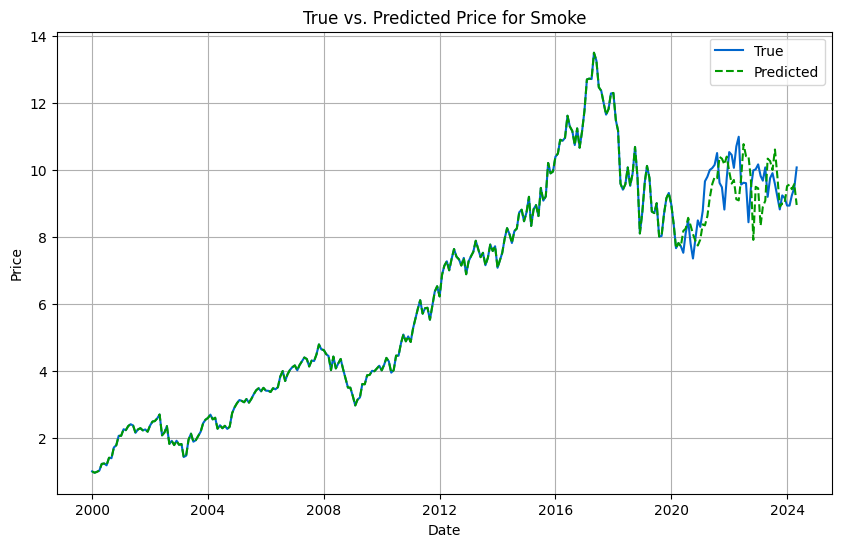

In [39]:
df_lstm_returns, df_lstm_prices = merge_pred_returns_and_prices(df_prices, lstm_pred_prices)

plot_prediction(actual_prices=df_prices, price_predictions=df_lstm_prices, industry_name='Smoke')

Display predictions for all industries provided by the LSTM model.

In [40]:
plot_industries_predictions(df_lstm_prices)

Loading BokehJS ...

Compute weights and display difference from LSTM price predictions

In [41]:
# Compute weights only from predicted timeframe
lstm_pred_weights = compute_weights(len(df_returns.columns),  df_lstm_returns[df_returns.shape[0]-len(lstm_pred_prices):])

# plot prediction vs and equally weighted portfolio
portfolio_perf(df_returns[df_returns.shape[0]-len(lstm_pred_prices):], lstm_pred_weights)

/var/folders/dg/c2dgqj9n6vjfcnsytns6g4ph0000gn/T/ipykernel_30933/2852449101.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


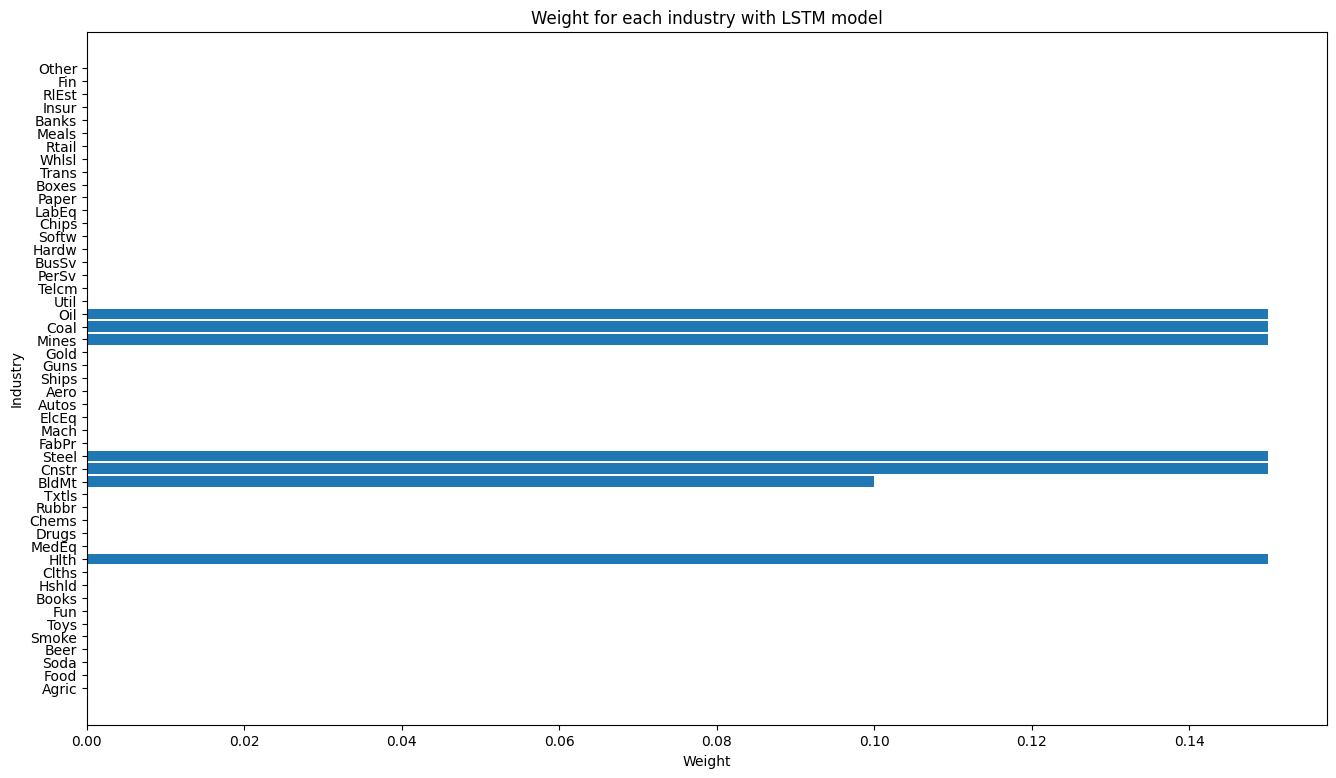

In [42]:
display_weights(lstm_pred_weights, "LSTM")

/var/folders/dg/c2dgqj9n6vjfcnsytns6g4ph0000gn/T/ipykernel_30933/2852449101.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


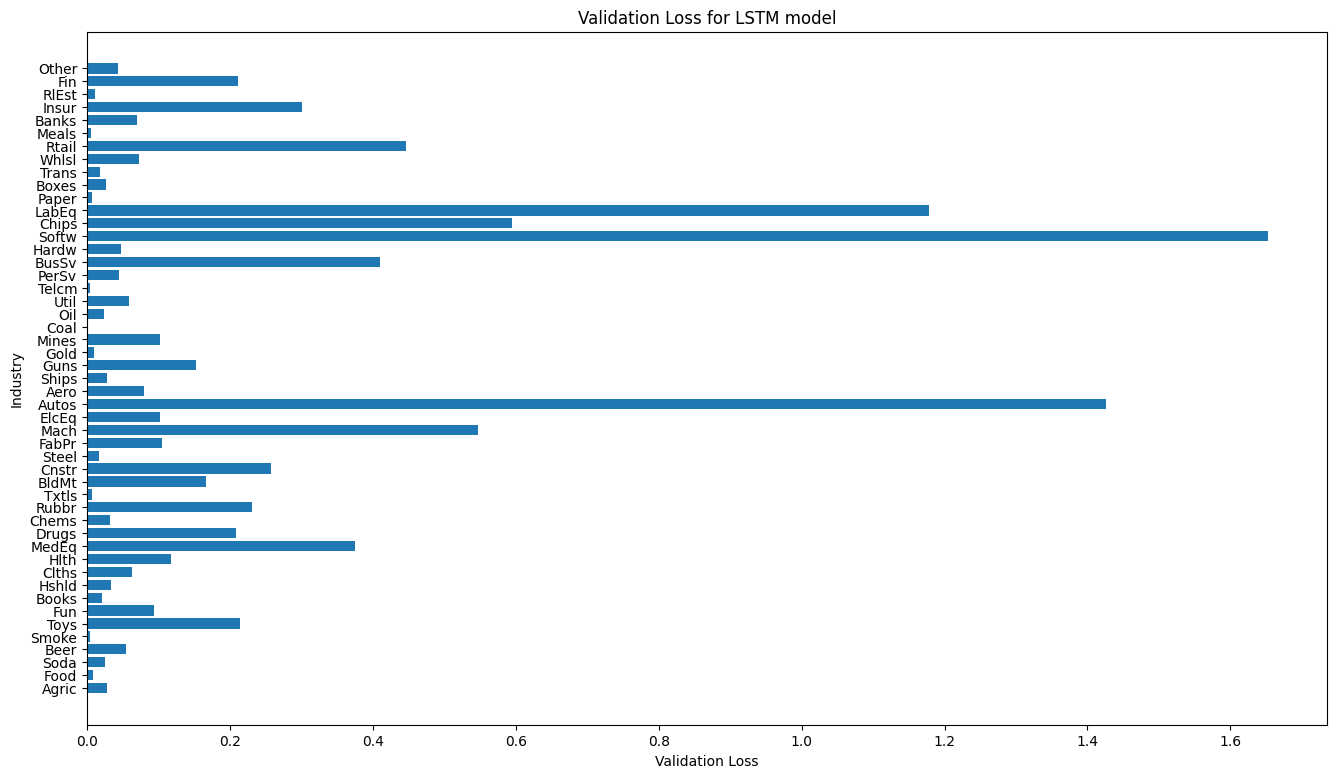

In [43]:
display_model_perf(lstm_model_perf, 'LSTM', 'Validation Loss')